# DCT-2D y Compresión de Imágenes
Note que el método Zig-Zag para codificación sigue el siguiente comportamiento 

![title](media/compresion-zigzag.svg)

\begin{equation}
x = [a_{11} \quad a_{12} \quad a_{21} \quad a_{31} \quad a_{22} \quad a_{13} \quad \ldots]
\end{equation}

In [1]:
function x = zigzag_v(A)
  % Funcion que implementa el algoritmo ZigZag para codificar una matriz
  % A: Matriz cuadrada de m x m
  % x: Vector con las diagonales diferentes de cero de A
  [m,~]=size(A); % Cantidad de filas y columnas
  n = floor((2*m-1)/2); % Numero de diagonales a partir de la principal
  diags = [flip(-n:n)]; % Diagonales de la matriz A
  s = sum(abs(A)(:));
  x = [];
  for d = diags
    c = m - abs(d); # Cantidad de elementos en la diagonal
    if (d>=0) i = c; j = 1; endif    
    if (d<0) i = m; j = abs(d)+1; endif
    
    % Se obtiene cada elemento de la diagonal uno a la vez
    diag = [];
    for e = 1:c
      diag = [diag A(i,j)];
      i-=1; j+=1;      
    endfor
    
    % Se agrega la diagonal al vector x
    if mod(abs(d),2) == 0 % Es una diagonal par
      % Los valores deben agregarse de arriba hacia abajo,
      % por eso se le hace un flip a la diagonal
      x = [x flip(diag)];
    else % Es una diagonal impar
      x = [x diag]; 
    endif  
    
    % Condicion de parada
    s1 = sum(abs(x));
    if s1 == s
      break;      
    endif
  endfor
endfunction

In [2]:
function A = zigzag_m(x,m)
  % Funcion que implementa el algoritmo ZigZag para decodificar una matriz
  % x: Vector con las diagonales diferentes de cero de A
  % m: Cantidad de filas y columnas de la matriz A
  % A: Matriz decodificada de m x m
  n = floor((2*m-1)/2); % Numero de diagonales a partir de la principal  
  diags = [flip(-n:n)]; % Diagonales de la matriz A
  s = sum(abs(x));
  A = zeros(m);
  l = 1; % Variable que determina el inicio de cada diagonal en el vector
  for d = diags
    c = m - abs(d); % Cantidad de elementos en la diagonal
    if (d>=0) i = c; j = 1; endif    
    if (d<0) i = m; j = abs(d)+1; endif
    
    elementos = x(l:l+c-1); % Elementos de la diagonal
    
    if mod(abs(d),2) == 0 % Es una diagonal par
      % Los valores de diagonales pares se agregan en la direccion
      % contraria, por eso se le hace un flip a los elementos
      elementos = flip(elementos);
    endif
    
    % Se inserta cada elemento en la matriz
    for e = 1:c
      A(i,j) = elementos(e);
      i-=1; j+=1;      
    endfor
    
    l = l+c; % Se actualiza el limite para la nueva diagonal
    
        % Condicion de parada
    s1 = sum(abs(A)(:));
    if s1 == s
      break;      
    endif
    
  endfor
endfunction

In [3]:
A = magic(5)
x = zigzag_v(A)
Ar = zigzag_m(x,5)

A =

   17   24    1    8   15
   23    5    7   14   16
    4    6   13   20   22
   10   12   19   21    3
   11   18   25    2    9

x =

 Columns 1 through 16:

   17   23   24    1    5    4   10    6    7    8   15   14   13   12   11   18

 Columns 17 through 25:

   19   20   16   22   21   25    2    3    9

Ar =

   17   24    1    8   15
   23    5    7   14   16
    4    6   13   20   22
   10   12   19   21    3
   11   18   25    2    9



Sea $A$ una matriz que se puede dividir en bloques de $8 \times 8$

![title](media/compresion3.svg)

## Comprimir imagen
Para comprimir una imagen, se divide la imagen en bloques y se aplica el algoritmo visto anteriormente a cada bloque. Para comprimir se necesitan los vectores de codificación, los cuales se guardan en un arreglo $M$ que tiene $p \times q$ entradas, y cada entrada representa el vector codificado de cada bloque.

![title](media/compresion4.svg)

In [4]:
function Q = matriz_cuantificacion(m)
  Q50=[16 11 10 16 24 40 51 61;
     12 12 14 19 26 58 60 55;
     14 13 16 24 40 57 59 56;
     14 17 22 29 51 87 80 62;
     18 22 37 56 68 109 103 77;
     24 35 55 64 81 104 113 92;
     49 64 78 87 103 121 120 101;
     72 92 95 98 112 100 103 99]; % Matriz de cuantificacion
  
  if m>50
    Q = floor(((100-m)/50)*Q50);
  elseif m<50 
    Q = floor((50/m)*Q50);
  else
    Q = Q50;
  endif 
endfunction

In [5]:
function B = comprimir_jpeg(A,c=50)
  % Funcion que implementa el algoritmo JPEG para comprimir una imagen
  % A: imagen a comprimir en formato double con valores en {0,1,...,255}
  %    esta imagen tiene que tener dimensiones multiplos de 8
  % c: Valor de compresion 0 <= c <= 100
  % B: Cell con la matriz codificada
  [m,n] = size(A);
  m = fix(m/8); n = fix(n/8);
  B = cell(m,n);
  % Se divide la imagen en bloques de 8x8
  for i = 1:m
    i_fin = 8*i;
    i_ini = i_fin - 7;
    for j = 1:n
      j_fin = j*8;
      j_ini = j_fin-7;
      bloque = A(i_ini:i_fin,j_ini:j_fin); % Se obtiene un bloque de 8x8
      
      % Paso 1: Restar 128 en cada una de las entradas de la matriz A
      M = bloque-128;
      
      % Paso 2: Calcular la DCT-2D de M
      D = dct2(M);
      
      % Paso 3: Calcular la matriz cuantificada     
      Q = matriz_cuantificacion(c);
      C = round(D./Q);
      
      % Paso 4: Codificacion en vector x
      x = zigzag_v(C);
      B(i,j) = x;
    endfor
  endfor  
endfunction

## Descomprimir imagen

![title](media/compresion5.svg)

In [6]:
function A = descomprimir_jpeg(B,c=50)
  % Funcion que implementa el algoritmo JPEG para descomprimir una imagen
  % B: Cell con la matriz codificada
  % c: Valor de compresion 0 <= c <= 100
  % A: imagen descomprimida en formato double con valores en {0,1,...,255}
  [m,n] = size(B);
  A = zeros(m*8,n*8);
  % Se obtienen los vectores comprimidos de los bloques de 8x8
  for i = 1:m
    i_fin = 8*i;
    i_ini = i_fin - 7;
    for j = 1:n
      j_fin = j*8;
      j_ini = j_fin-7;
      x = B{i,j};
      
      % Paso 1: Decodificar el vector x
      Cr = zigzag_m(x,8);
      
      % Paso 2: Multiplicar puntualmente la matriz C con la matriz Q
      Q = matriz_cuantificacion(c);
      M = Q.*Cr;
      
      % Paso 3: Calcular la inversa de la DCT-2D y redondear
      N = round(idct2(M));
      
      % Paso 4: Sumar 128 a cada una de las entradas
      Ar = N+128;
      
      A(i_ini:i_fin,j_ini:j_fin) = Ar; % Se guarda el bloque de 8x8
    endfor
  endfor
endfunction

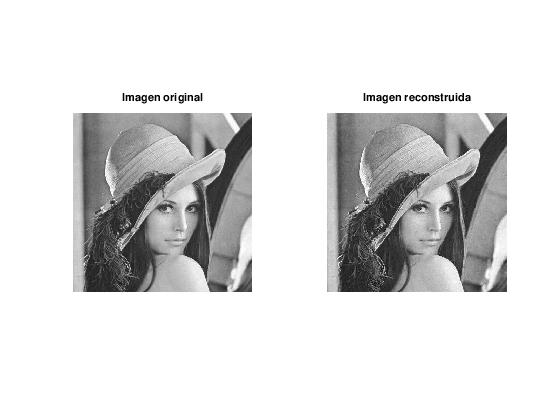

In [7]:
pkg load signal;

A = imread('media/comprimir.jpg');
A = double(A);
B = comprimir_jpeg(A);

Ar = descomprimir_jpeg(B);
Ar = uint8(Ar);

subplot(1,2,1);
imshow(uint8(A));
title('Imagen original');

subplot(1,2,2);
imshow(Ar);
title('Imagen reconstruida');